In [1]:
import numpy as np
import scipy
import scipy.spatial
from scipy.spatial.distance import squareform,pdist,cdist
import matplotlib.pyplot as plt
from scipy.io import mmread

from sklearn.manifold import TSNE
from joblib import Parallel, delayed

from timeit import default_timer as timer

from PIL import Image


In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


# Experimnet

### understand how to load data 

In [2]:
import os

data_dir= ''
arr = os.listdir(data_dir )


In [3]:
modality= np.array([int(filename[1]) for filename in arr])
time  = np.array([int(filename[3:9]) for filename in arr])
time_vals= np.sort(np.unique(time))

###  load data

In [4]:
n=5000
orig_sin_im_size= np.array([60, 80])
orig_im_size = orig_sin_im_size+0
orig_im_size[1]*=2


sub_rate =4
sing_im_size = np.prod(orig_sin_im_size)
im_size= np.prod(orig_im_size)
x= np.zeros((n, im_size))


for i,cur_time in enumerate(time_vals[:n]):
    inds= np.where(np.array(time)==cur_time)[0]
    
    inds= inds[np.argsort(modality[inds])]
    
    curr_im= np.zeros(orig_im_size)
    for t in range(2):
        im = Image.open(data_dir+'/'+arr[inds[t]]).convert('L')        
        curr_im[:,t*orig_sin_im_size[1]:(t+1)*orig_sin_im_size[1]]= np.array(im)[::sub_rate,::sub_rate]/255.
        
    x[i,:]=curr_im.flatten()


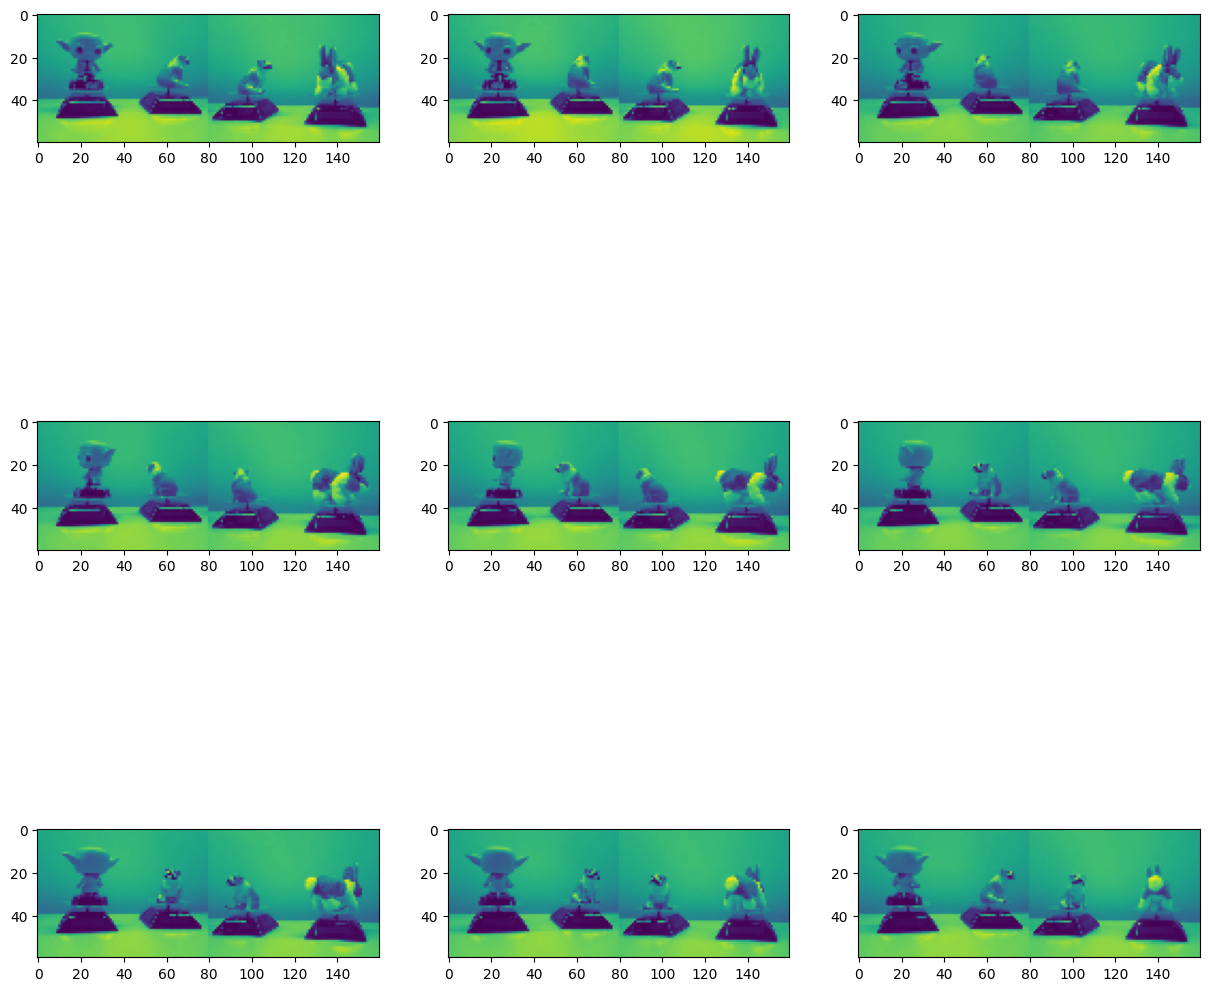

In [5]:
amount_figs=9

f,ax= plt.subplots(3,3,figsize=(15,15))
for i in range(amount_figs):
    ax.flatten()[i].imshow(x[i,:].reshape(orig_im_size))
    


# Extract colors

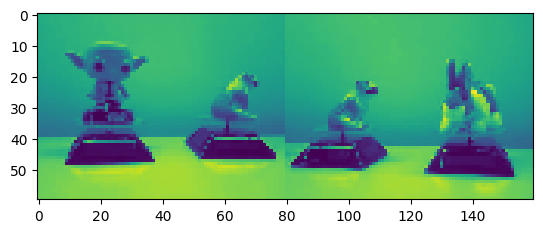

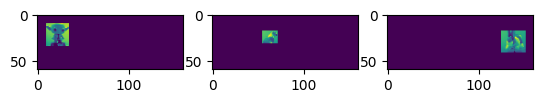

In [6]:
plt.figure()
plt.imshow(x[0,:].reshape(orig_im_size))

mask1 = x[0,:].reshape(orig_im_size)*0.
mask1[10:35,10:35]=1.
mask1 = mask1.flatten()

mask2 = x[0,:].reshape(orig_im_size)*0.
mask2[18:32,55:72]=1.
mask2 = mask2.flatten()

mask3 = x[0,:].reshape(orig_im_size)*0.
mask3[18:42,125:152]=1.
mask3 = mask3.flatten()

f,ax = plt.subplots(1,3)
ax[0].imshow((x[0,:]*mask1).reshape(orig_im_size))
ax[1].imshow((x[0,:]*mask2).reshape(orig_im_size))
ax[2].imshow((x[0,:]*mask3).reshape(orig_im_size))


In [7]:
from sklearn.neighbors import NearestNeighbors

# Computes the diffusion map embedding of the given dataset.
#
# Diffusion maps are a spectral dimensionality reduction technique that captures 
# the intrinsic geometry of the data using a diffusion process defined over the data graph.
#
# Parameters:
#   data : np.ndarray of shape (N, D)
#       Input data matrix with N samples and D features.
#
#   n_neighbors : int (default=10)
#       Number of nearest neighbors used to estimate the Gaussian kernel bandwidth (sigma).
#
#   embedding_dim : int (default=10)
#       Number of diffusion components (eigenvectors/eigenvalues) to retain in the embedding.
#
#   alpha : float (default=1.0)
#       Normalization parameter for the kernel matrix:
#           - alpha = 0 → no normalization
#           - alpha = 1 → standard normalization (removes sampling density influence)
#           - 0 < alpha < 1 interpolates between the two
#
# Returns:
#   embedding : np.ndarray of shape (N, embedding_dims)
#       The diffusion map embedding of the input data. Each row is a low-dimensional
#       representation of a sample based on the leading diffusion components.

def diffusion_maps(data, n_neighbors=10, embedding_dim= 10 ,alpha=1.):
    
    dist= scipy.spatial.distance.cdist(data,data)**2
    
    sigma = np.max(np.partition(dist,n_neighbors,axis=1)[:,n_neighbors])
    W = np.exp(-dist**2 / (2 * sigma**2))   
    D = np.sum(W, axis=1,keepdims=True)
    if alpha>0.:
        W= (1/D**alpha)*W*(1/(D.T)**(alpha))
        D = np.sum(W, axis=1,keepdims=True)
    M = 1/D * W
    
    eigenvalues, eigenvectors = np.linalg.eig(M)
    
    idx = np.argsort(eigenvalues)[::-1][:embedding_dim]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    embedding = np.real(eigenvectors *eigenvalues)

    return embedding

In [8]:
yoda_dmaps = diffusion_maps(x[:,np.where(mask1>0)[0]])
dog_dmaps  = diffusion_maps(x[:,np.where(mask2>0)[0]])
bunny_dmaps  = diffusion_maps(x[:,np.where(mask3>0)[0]])

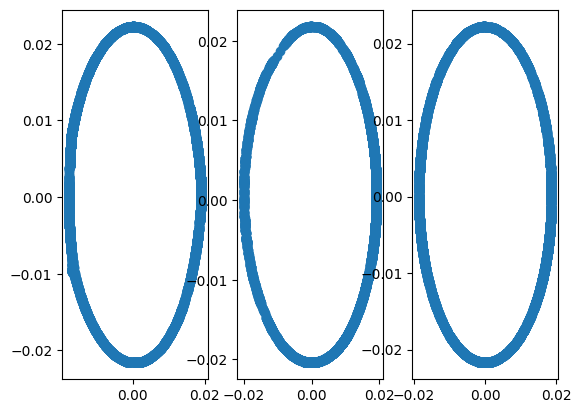

In [9]:
f,ax= plt.subplots(1,3)
ax[0].scatter(yoda_dmaps[:,1],yoda_dmaps[:,2])
ax[1].scatter(dog_dmaps[:,1],dog_dmaps[:,2])
ax[2].scatter(bunny_dmaps[:,1],bunny_dmaps[:,2])

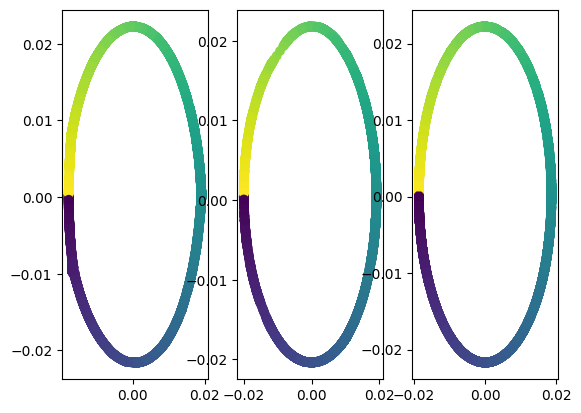

In [10]:
dog_mid= (np.max(dog_dmaps,axis=0)+np.min(dog_dmaps,axis=0))/2
yoda_mid= (np.max(yoda_dmaps,axis=0)+np.min(yoda_dmaps,axis=0))/2
bunny_mid= (np.max(bunny_dmaps,axis=0)+np.min(bunny_dmaps,axis=0))/2

c_yoda= np.arctan2(yoda_dmaps[:,2]-yoda_mid[2],yoda_dmaps[:,1]-yoda_mid[1])
c_dog= np.arctan2(dog_dmaps[:,2]-dog_mid[2],dog_dmaps[:,1]-dog_mid[1])
c_bunny= np.arctan2(bunny_dmaps[:,2]-bunny_mid[2],bunny_dmaps[:,1]-bunny_mid[1])

f,ax= plt.subplots(1,3)
ax[0].scatter(yoda_dmaps[:,1],yoda_dmaps[:,2],c=c_yoda)
ax[1].scatter(dog_dmaps[:,1],dog_dmaps[:,2],c=c_dog)
ax[2].scatter(bunny_dmaps[:,1],bunny_dmaps[:,2],c=c_bunny)

### Run experiment 

In [11]:
from FP import *

In [ ]:
K=3

fp = FP(  perplexity=10, K=K)
fp.fit(x, verbose=True,simulations=100)

# Show results

In [ ]:
omega = fp.get_optimal_parameters()['omega']
feat_partitions = fp.get_feature_partitions()

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

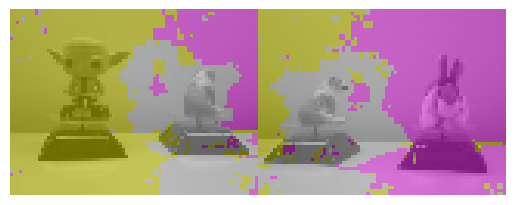

In [92]:
mask1 = (omega[0]).reshape(orig_im_size)
mask2 = (omega[1]).reshape(orig_im_size)
mask3 = (omega[2]).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

In [24]:
from sklearn.manifold import TSNE
emb_all = TSNE(n_components=2, perplexity=40).fit_transform(x)

emb_ours = [TSNE(n_components=2,  perplexity=110).fit_transform(x[:,feat_partitions[i,:]]) for i in range(K) ] 

In [26]:
emb_all_dmaps= diffusion_maps(x)

In [27]:
emb_ours_dmaps = [diffusion_maps(x[:,feat_partitions[i]]) for i in range(K) ] 

In [29]:
import umap
emb_all_umap = umap.UMAP(n_components=2).fit_transform(x)
emb_ours_umap = [umap.UMAP(n_components=2,n_neighbors=80).fit_transform(x[:,feat_partitions[i]) for i in range(K) ] 


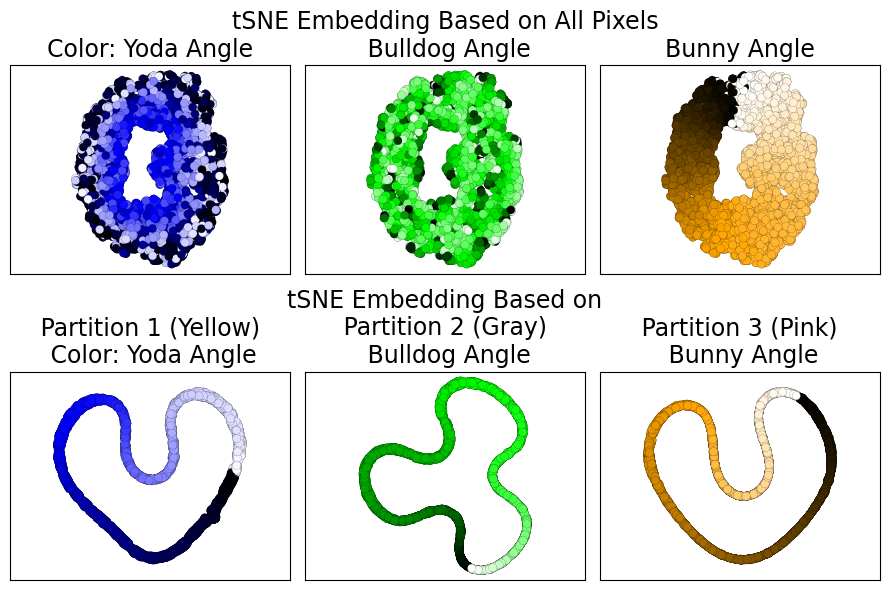

In [66]:
norm_yoda = plt.Normalize(np.min(c_yoda), np.max(c_yoda))
cmap_yoda = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (0, 0, 1), (0, 0, 0)])

norm_dog = plt.Normalize(np.min(c_yoda), np.max(c_yoda))
cmap_dog = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (0, 1, 0), (0, 0, 0)])

norm_bunny = plt.Normalize(np.min(c_bunny), np.max(c_bunny))
cmap_bunny = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (1, 0.647, 0), (0, 0, 0)])


order= np.random.permutation(len(emb_all))

f,ax= plt.subplots(2,3,figsize=(9,6))

ax[0,0].scatter(emb_all[order,0],emb_all[order,1],c=c_yoda[order], cmap=cmap_yoda, norm= norm_yoda,edgecolor='black',linewidth=0.1)
ax[0,1].scatter(emb_all[order,0],emb_all[order,1],c=c_dog[order], cmap=cmap_dog, norm= norm_dog,edgecolor='black',linewidth=0.1)
ax[0,2].scatter(emb_all[order,0],emb_all[order,1],c=c_bunny[order], cmap=cmap_bunny, norm= norm_bunny,edgecolor='black',linewidth=0.1)

ax[1,0].scatter(emb_ours[0][order,0],emb_ours[0][order,1],c=-c_yoda[order], cmap=cmap_yoda, norm= norm_yoda,edgecolor='black',linewidth=0.1)
ax[1,1].scatter(emb_ours[1][order,0],emb_ours[1][order,1],c=-c_dog[order], cmap=cmap_dog, norm= norm_dog,edgecolor='black',linewidth=0.1)
ax[1,2].scatter(emb_ours[2][order,0],emb_ours[2][order,1],c=-c_bunny[order], cmap=cmap_bunny, norm= norm_bunny,edgecolor='black',linewidth=0.1)

ax[0,0].set_title('Color: Yoda Angle',fontsize=17)
ax[0,1].set_title('tSNE Embedding Based on All Pixels\n Bulldog Angle',fontsize=17)
ax[0,2].set_title('Bunny Angle',fontsize=17)


ax[1,0].set_title('\n Partition 1 (Yellow) \n Color: Yoda Angle',fontsize=17)
ax[1,1].set_title('tSNE Embedding Based on\n Partition 2 (Gray) \n Bulldog Angle',fontsize=17)
ax[1,2].set_title('\n Partition 3 (Pink) \n Bunny Angle',fontsize=17)

for i in range(2):
    for j in range(3):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].axis('equal')

plt.tight_layout()

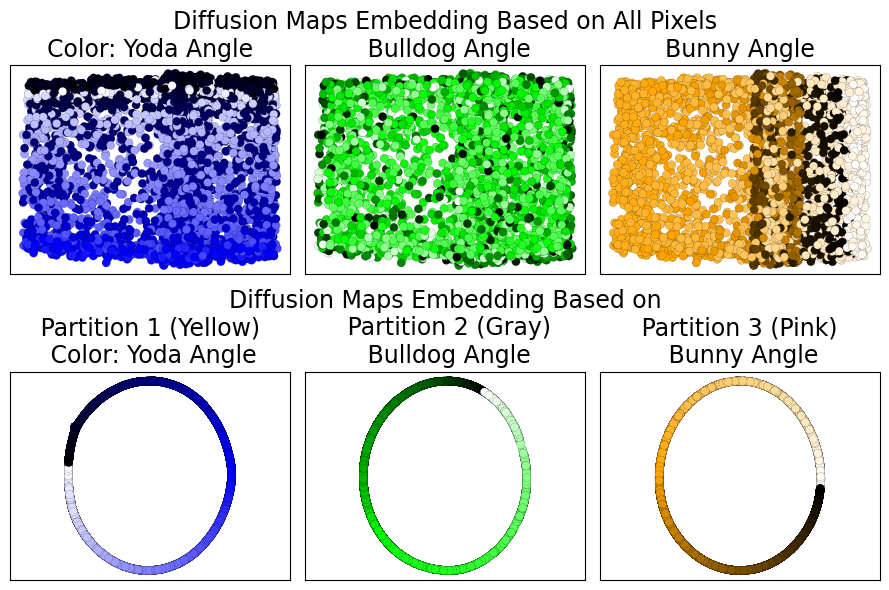

In [67]:
norm_yoda = plt.Normalize(np.min(c_yoda), np.max(c_yoda))
cmap_yoda = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (0, 0, 1), (0, 0, 0)])

norm_dog = plt.Normalize(np.min(c_yoda), np.max(c_yoda))
cmap_dog = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (0, 1, 0), (0, 0, 0)])

norm_bunny = plt.Normalize(np.min(c_bunny), np.max(c_bunny))
cmap_bunny = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (1, 0.647, 0), (0, 0, 0)])


order= np.random.permutation(len(x))

f,ax= plt.subplots(2,3,figsize=(9,6))

ax[0,0].scatter(emb_all_dmaps[order,1],emb_all_dmaps[order,2],c=c_yoda[order], cmap=cmap_yoda, norm= norm_yoda,edgecolor='black',linewidth=0.1)
ax[0,1].scatter(emb_all_dmaps[order,1],emb_all_dmaps[order,2],c=c_dog[order], cmap=cmap_dog, norm= norm_dog,edgecolor='black',linewidth=0.1)
ax[0,2].scatter(emb_all_dmaps[order,1],emb_all_dmaps[order,2],c=c_bunny[order], cmap=cmap_bunny, norm= norm_bunny,edgecolor='black',linewidth=0.1)

ax[1,0].scatter(emb_ours_dmaps[0][order,1],emb_ours_dmaps[0][order,2],c=-c_yoda[order], cmap=cmap_yoda, norm= norm_yoda,edgecolor='black',linewidth=0.1)
ax[1,1].scatter(emb_ours_dmaps[1][order,1],emb_ours_dmaps[1][order,2],c=-c_dog[order], cmap=cmap_dog, norm= norm_dog,edgecolor='black',linewidth=0.1)
ax[1,2].scatter(emb_ours_dmaps[2][order,1],emb_ours_dmaps[2][order,2],c=-c_bunny[order], cmap=cmap_bunny, norm= norm_bunny,edgecolor='black',linewidth=0.1)

ax[0,0].set_title('Color: Yoda Angle',fontsize=17)
ax[0,1].set_title('Diffusion Maps Embedding Based on All Pixels\n Bulldog Angle',fontsize=17)
ax[0,2].set_title('Bunny Angle',fontsize=17)


ax[1,0].set_title('\n Partition 1 (Yellow) \n Color: Yoda Angle',fontsize=17)
ax[1,1].set_title('Diffusion Maps Embedding Based on\n Partition 2 (Gray)\n Bulldog Angle',fontsize=17)
ax[1,2].set_title('\n Partition 3 (Pink) \n Bunny Angle',fontsize=17)

for i in range(2):
    for j in range(3):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].axis('equal')

plt.tight_layout()

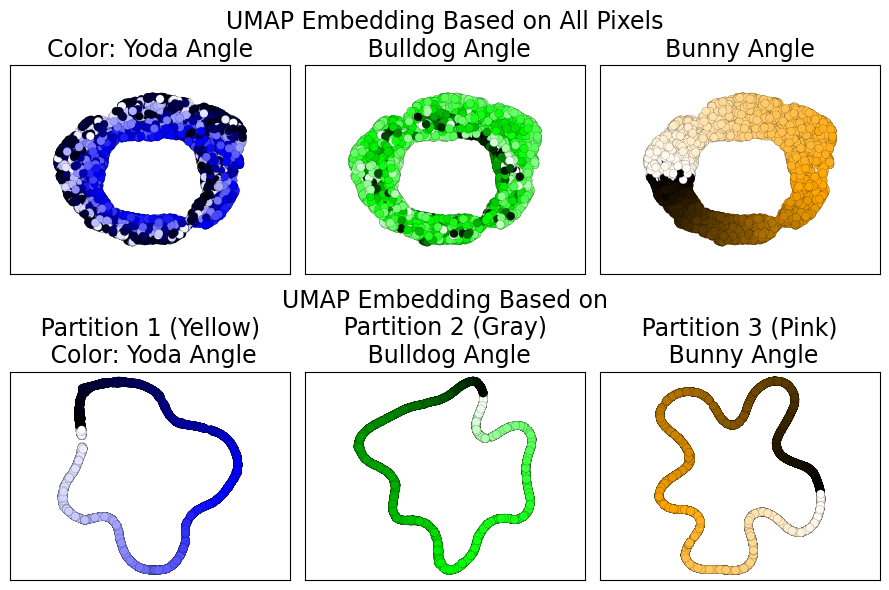

In [68]:
norm_yoda = plt.Normalize(np.min(c_yoda), np.max(c_yoda))
cmap_yoda = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (0, 0, 1), (0, 0, 0)])

norm_dog = plt.Normalize(np.min(c_yoda), np.max(c_yoda))
cmap_dog = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (0, 1, 0), (0, 0, 0)])

norm_bunny = plt.Normalize(np.min(c_bunny), np.max(c_bunny))
cmap_bunny = plt.cm.colors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1), (1, 0.647, 0), (0, 0, 0)])


order= np.random.permutation(len(x))

f,ax= plt.subplots(2,3,figsize=(9,6))

ax[0,0].scatter(emb_all_umap[order,0],emb_all_umap[order,1],c=c_yoda[order], cmap=cmap_yoda, norm= norm_yoda,edgecolor='black',linewidth=0.1)
ax[0,1].scatter(emb_all_umap[order,0],emb_all_umap[order,1],c=c_dog[order], cmap=cmap_dog, norm= norm_dog,edgecolor='black',linewidth=0.1)
ax[0,2].scatter(emb_all_umap[order,0],emb_all_umap[order,1],c=c_bunny[order], cmap=cmap_bunny, norm= norm_bunny,edgecolor='black',linewidth=0.1)

ax[1,0].scatter(emb_ours_umap[0][order,0],emb_ours_umap[0][order,1],c=-c_yoda[order], cmap=cmap_yoda, norm= norm_yoda,edgecolor='black',linewidth=0.1)
ax[1,1].scatter(emb_ours_umap[1][order,0],emb_ours_umap[1][order,1],c=-c_dog[order], cmap=cmap_dog, norm= norm_dog,edgecolor='black',linewidth=0.1)
ax[1,2].scatter(emb_ours_umap[2][order,0],emb_ours_umap[2][order,1],c=-c_bunny[order], cmap=cmap_bunny, norm= norm_bunny,edgecolor='black',linewidth=0.1)

ax[0,0].set_title('Color: Yoda Angle',fontsize=17)
ax[0,1].set_title('UMAP Embedding Based on All Pixels\n Bulldog Angle',fontsize=17)
ax[0,2].set_title('Bunny Angle',fontsize=17)


ax[1,0].set_title('\n Partition 1 (Yellow) \n Color: Yoda Angle',fontsize=17)
ax[1,1].set_title('UMAP Embedding Based on\n Partition 2 (Gray) \n Bulldog Angle',fontsize=17)
ax[1,2].set_title('\n Partition 3 (Pink) \n Bunny Angle',fontsize=17)

for i in range(2):
    for j in range(3):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].axis('equal')

plt.tight_layout()

# Compare with other clustering techniques (applied on the features)

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

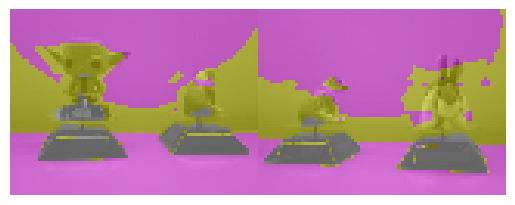

In [75]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(x.T)
kmeans_K3_labels= kmeans.labels_+0

mask1 = (kmeans_K3_labels==0).reshape(orig_im_size)
mask2 = (kmeans_K3_labels==1).reshape(orig_im_size)
mask3 = (kmeans_K3_labels==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

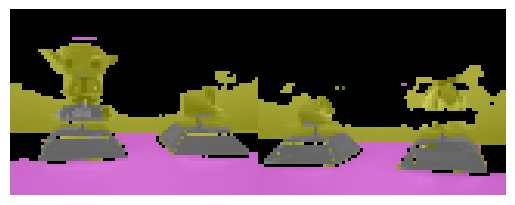

In [74]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(x.T)
kmeans_K4_labels= kmeans.labels_+0


mask1 = (kmeans_K4_labels==0).reshape(orig_im_size)
mask2 = (kmeans_K4_labels==1).reshape(orig_im_size)
mask3 = (kmeans_K4_labels==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

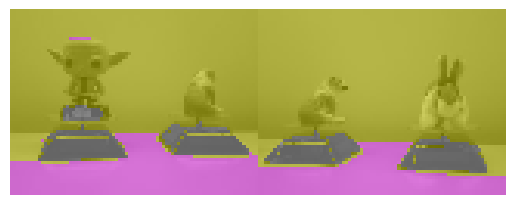

In [76]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=3, 
    affinity='nearest_neighbors',  # Use k-nearest neighbors graph
    n_neighbors=10,  # Number of neighbors to use for the graph
    random_state=42
)
spectral_labels_K3_10N = spectral.fit_predict(x.T)

mask1 = (spectral_labels_K3_10N==0).reshape(orig_im_size)
mask2 = (spectral_labels_K3_10N==1).reshape(orig_im_size)
mask3 = (spectral_labels_K3_10N==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

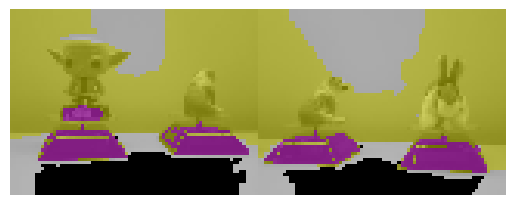

In [91]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=4, 
    affinity='nearest_neighbors',  # Use k-nearest neighbors graph
    n_neighbors=10,  # Number of neighbors to use for the graph
    random_state=0
)
spectral_labels_K4_10N = spectral.fit_predict(x.T)

mask1 = (spectral_labels_K4_10N==0).reshape(orig_im_size)
mask2 = (spectral_labels_K4_10N==1).reshape(orig_im_size)
mask3 = (spectral_labels_K4_10N==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

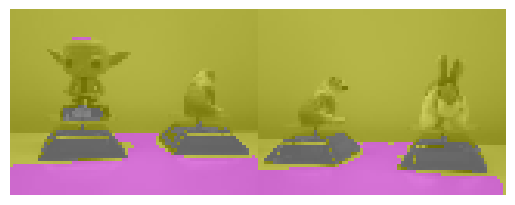

In [90]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=3, 
    affinity='nearest_neighbors',  # Use k-nearest neighbors graph
    n_neighbors=30,  # Number of neighbors to use for the graph
    random_state=42
)
spectral_labels_K3_30N = spectral.fit_predict(x.T)

mask1 = (spectral_labels_K3_30N==0).reshape(orig_im_size)
mask2 = (spectral_labels_K3_30N==1).reshape(orig_im_size)
mask3 = (spectral_labels_K3_30N==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

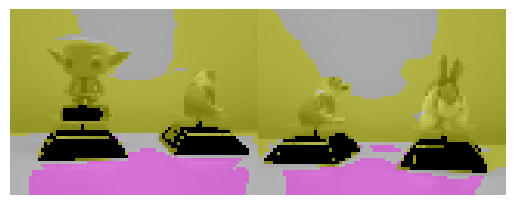

In [89]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=4, 
    affinity='nearest_neighbors',  # Use k-nearest neighbors graph
    n_neighbors=30,  # Number of neighbors to use for the graph
    random_state=42
)
spectral_labels_K4_30N = spectral.fit_predict(x.T)

mask1 = (spectral_labels_K4_30N==0).reshape(orig_im_size)
mask2 = (spectral_labels_K4_30N==1).reshape(orig_im_size)
mask3 = (spectral_labels_K4_30N==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

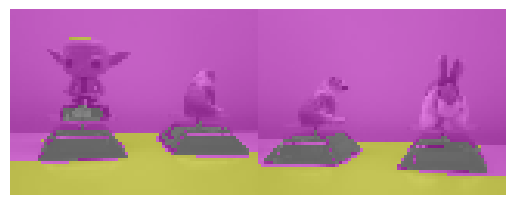

In [88]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=3, 
    n_components=5,
    affinity='nearest_neighbors',  # Use k-nearest neighbors graph
    n_neighbors=10,  # Number of neighbors to use for the graph
    random_state=42
)
spectral_labels_K3_10N_more_eigs = spectral.fit_predict(x.T)

mask1 = (spectral_labels_K3_10N_more_eigs==0).reshape(orig_im_size)
mask2 = (spectral_labels_K3_10N_more_eigs==1).reshape(orig_im_size)
mask3 = (spectral_labels_K3_10N_more_eigs==2).reshape(orig_im_size)


yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

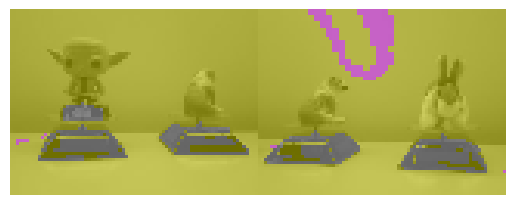

In [87]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=3, 
    n_components=10,
    affinity='nearest_neighbors',  # Use k-nearest neighbors graph
    n_neighbors=10,  # Number of neighbors to use for the graph
    random_state=42
)
spectral_labels_K3_10N_more_eigs2 = spectral.fit_predict(x.T)

mask1 = (spectral_labels_K3_10N_more_eigs2==0).reshape(orig_im_size)
mask2 = (spectral_labels_K3_10N_more_eigs2==1).reshape(orig_im_size)
mask3 = (spectral_labels_K3_10N_more_eigs2==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

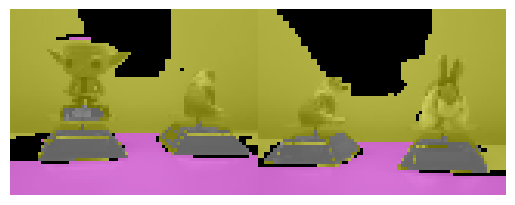

In [86]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=4, 
    n_components=5,
    affinity='nearest_neighbors',  # Use k-nearest neighbors graph
    n_neighbors=10,  # Number of neighbors to use for the graph
    random_state=42
)
spectral_labels_K4_10N_more_eigs = spectral.fit_predict(x.T)

mask1 = (spectral_labels_K4_10N_more_eigs==0).reshape(orig_im_size)
mask2 = (spectral_labels_K4_10N_more_eigs==1).reshape(orig_im_size)
mask3 = (spectral_labels_K4_10N_more_eigs==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

(np.float64(-0.5), np.float64(159.5), np.float64(59.5), np.float64(-0.5))

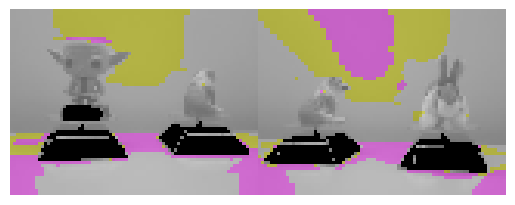

In [85]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=4, 
    n_components=10,
    affinity='nearest_neighbors',  # Use k-nearest neighbors graph
    n_neighbors=30,  # Number of neighbors to use for the graph
    random_state=42
)
spectral_labels_K4_10N_more_eigs2 = spectral.fit_predict(x.T)


mask1 = (spectral_labels_K4_10N_more_eigs2==0).reshape(orig_im_size)
mask2 = (spectral_labels_K4_10N_more_eigs2==1).reshape(orig_im_size)
mask3 = (spectral_labels_K4_10N_more_eigs2==2).reshape(orig_im_size)

yellow = np.array([220, 220,0], dtype=np.uint8)/255.
gray = np.array([200, 200, 200], dtype=np.uint8)/255.
pink = np.array([255, 55, 255], dtype=np.uint8)/255.


tot_data= np.zeros( list(np.array(orig_im_size))+[3])
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ yellow[None,None,:])*.5*mask1[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ gray[None,None,:])*0.5*mask2[:,:,None]
tot_data[:,:,:]+= (x[1].reshape(np.array(orig_im_size))[:,:,None]+ pink[None,None,:])*0.5*mask3[:,:,None]

plt.figure()
plt.imshow(tot_data)
plt.axis('off')

In [102]:
from sklearn.neighbors import NearestNeighbors

def get_nearest_neighbors( data ,n_neighbors=50):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='auto')
    nbrs.fit(data)
    _, indices = nbrs.kneighbors(data)
    return indices[:,1:]

In [103]:
n_neighbors= 50
yoda_nn= get_nearest_neighbors( yoda_dmaps[:,1:3], n_neighbors=n_neighbors)
dog_nn= get_nearest_neighbors( dog_dmaps[:,1:3],n_neighbors=n_neighbors)
bunny_nn= get_nearest_neighbors( bunny_dmaps[:,1:3],n_neighbors=n_neighbors)
gt_nn= np.concatenate([yoda_nn[None,:,:], dog_nn[None,:,:], bunny_nn[None,:,:]],axis=0)

allfeats_nn = get_nearest_neighbors(x)
fp_nn =  np.concatenate([get_nearest_neighbors( x[:,feat_partitions[i]])[None,:,:] for i in range(3)],axis=0)
kmean_K3_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(kmeans_K3_labels==i)[0]])[None,:,:] for i in range(3)],axis=0)
kmean_K4_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(kmeans_K4_labels==i)[0]])[None,:,:] for i in range(4)],axis=0)
spectral_K3_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(spectral_labels_K3_10N==i)[0]])[None,:,:] for i in range(3)],axis=0)
spectral_K4_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(spectral_labels_K4_10N==i)[0]])[None,:,:] for i in range(4)],axis=0)

spectral_K3_30N_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(spectral_labels_K3_30N==i)[0]])[None,:,:] for i in range(3)],axis=0)
spectral_K3_40N_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(spectral_labels_K4_30N==i)[0]])[None,:,:] for i in range(4)],axis=0)

spectral_K3_10N_more_eigs_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(spectral_labels_K3_10N_more_eigs==i)[0]])[None,:,:] for i in range(3)],axis=0)
spectral_K4_10N_more_eigs_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(spectral_labels_K4_10N_more_eigs==i)[0]])[None,:,:] for i in range(4)],axis=0)

spectral_K3_10N_more_eigs2_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(spectral_labels_K3_10N_more_eigs2==i)[0]])[None,:,:] for i in range(3)],axis=0)
spectral_K4_10N_more_eigs2_nn = np.concatenate([get_nearest_neighbors(x[:,np.where(spectral_labels_K4_10N_more_eigs2==i)[0]])[None,:,:] for i in range(4)],axis=0)


In [104]:
use_subset_nn= 30

allfeats_res2 = get_common(gt_nn[:,:,:use_subset_nn], [allfeats_nn[:,:use_subset_nn]])/use_subset_nn*100
fp_res2 =  get_common(gt_nn[:,:,:use_subset_nn], fp_nn[:,:,:use_subset_nn])/use_subset_nn*100
kmean_K3_res2 = get_common(gt_nn[:,:,:use_subset_nn], kmean_K3_nn[:,:,:use_subset_nn])/use_subset_nn*100
kmean_K4_res2 = get_common(gt_nn[:,:,:use_subset_nn], kmean_K4_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K3_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K4_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K4_nn[:,:,:use_subset_nn])/use_subset_nn*100

spectral_K3_30N_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_30N_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K3_40N_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_40N_nn[:,:,:use_subset_nn])/use_subset_nn*100

spectral_K3_10N_more_eigs_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_10N_more_eigs_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K4_10N_more_eigs_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K4_10N_more_eigs_nn[:,:,:use_subset_nn])/use_subset_nn*100

spectral_K3_10N_more_eigs2_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_10N_more_eigs2_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K4_10N_more_eigs2_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K4_10N_more_eigs2_nn[:,:,:use_subset_nn])/use_subset_nn*100

def print_data_res(data,name):
    mean = np.mean(data,axis=-1)
    best_gt_dim = np.argmax( mean,axis=1)    
    best_mean = np.max(mean,axis=1)
    best_std= np.std(data[np.arange(len(best_gt_dim)), best_gt_dim,:],axis=-1)
    print(name+':'+str(np.round(np.mean(best_mean),2))+'   :  '+str(np.round(np.mean(best_std),2)))

print_data_res(allfeats_res2,'all')
print_data_res(fp_res2,'fp')
print_data_res(kmean_K3_res2,'kmeans 3')
print_data_res(kmean_K4_res2,'kmeans 4')
print_data_res(spectral_K3_res2,'spectral 3')
print_data_res(spectral_K4_res2,'spectral 4')

print_data_res(spectral_K3_30N_res2,'spectral 3- 30n')
print_data_res(spectral_K3_40N_res2,'spectral 4- 30n')
print_data_res(spectral_K3_10N_more_eigs_res2,'spectral 3- more eigs')
print_data_res(spectral_K4_10N_more_eigs_res2,'spectral 4- more eigs')
print_data_res(spectral_K3_10N_more_eigs2_res2,'spectral 3- more eigs2')
print_data_res(spectral_K4_10N_more_eigs2_res2,'spectral 4- more eigs2')

all:8.21   :  4.91
fp:75.92   :  12.21
kmeans 3:18.49   :  9.74
kmeans 4:18.23   :  9.11
spectral 3:18.28   :  8.4
spectral 4:18.85   :  8.71
spectral 3- 30n:18.12   :  8.5
spectral 4- 30n:18.19   :  8.5
spectral 3- more eigs:18.04   :  8.5
spectral 4- more eigs:18.63   :  8.76
spectral 3- more eigs2:17.51   :  7.94
spectral 4- more eigs2:18.93   :  10.35


In [105]:
use_subset_nn= 50

allfeats_res2 = get_common(gt_nn[:,:,:use_subset_nn], [allfeats_nn[:,:use_subset_nn]])/use_subset_nn*100
fp_res2 =  get_common(gt_nn[:,:,:use_subset_nn], fp_nn[:,:,:use_subset_nn])/use_subset_nn*100
kmean_K3_res2 = get_common(gt_nn[:,:,:use_subset_nn], kmean_K3_nn[:,:,:use_subset_nn])/use_subset_nn*100
kmean_K4_res2 = get_common(gt_nn[:,:,:use_subset_nn], kmean_K4_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K3_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K4_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K4_nn[:,:,:use_subset_nn])/use_subset_nn*100

spectral_K3_30N_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_30N_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K3_40N_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_40N_nn[:,:,:use_subset_nn])/use_subset_nn*100

spectral_K3_10N_more_eigs_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_10N_more_eigs_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K4_10N_more_eigs_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K4_10N_more_eigs_nn[:,:,:use_subset_nn])/use_subset_nn*100

spectral_K3_10N_more_eigs2_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K3_10N_more_eigs2_nn[:,:,:use_subset_nn])/use_subset_nn*100
spectral_K4_10N_more_eigs2_res2 = get_common(gt_nn[:,:,:use_subset_nn], spectral_K4_10N_more_eigs2_nn[:,:,:use_subset_nn])/use_subset_nn*100

def print_data_res(data,name):
    mean = np.mean(data,axis=-1)
    best_gt_dim = np.argmax( mean,axis=1)    
    best_mean = np.max(mean,axis=1)
    best_std= np.std(data[np.arange(len(best_gt_dim)), best_gt_dim,:],axis=-1)
    print(name+':'+str(np.round(np.mean(best_mean),2))+'   :  '+str(np.round(np.mean(best_std),2)))

print_data_res(allfeats_res2,'all')
print_data_res(fp_res2,'fp')
print_data_res(kmean_K3_res2,'kmeans 3')
print_data_res(kmean_K4_res2,'kmeans 4')
print_data_res(spectral_K3_res2,'spectral 3')
print_data_res(spectral_K4_res2,'spectral 4')

print_data_res(spectral_K3_30N_res2,'spectral 3- 30n')
print_data_res(spectral_K3_40N_res2,'spectral 4- 30n')
print_data_res(spectral_K3_10N_more_eigs_res2,'spectral 3- more eigs')
print_data_res(spectral_K4_10N_more_eigs_res2,'spectral 4- more eigs')
print_data_res(spectral_K3_10N_more_eigs2_res2,'spectral 3- more eigs2')
print_data_res(spectral_K4_10N_more_eigs2_res2,'spectral 4- more eigs2')

all:11.74   :  4.75
fp:85.14   :  8.58
kmeans 3:25.93   :  10.61
kmeans 4:25.42   :  10.31
spectral 3:24.72   :  8.82
spectral 4:25.49   :  9.19
spectral 3- 30n:24.47   :  8.97
spectral 4- 30n:24.53   :  8.98
spectral 3- more eigs:24.41   :  8.98
spectral 4- more eigs:25.25   :  9.26
spectral 3- more eigs2:23.8   :  8.22
spectral 4- more eigs2:25.49   :  11.51
